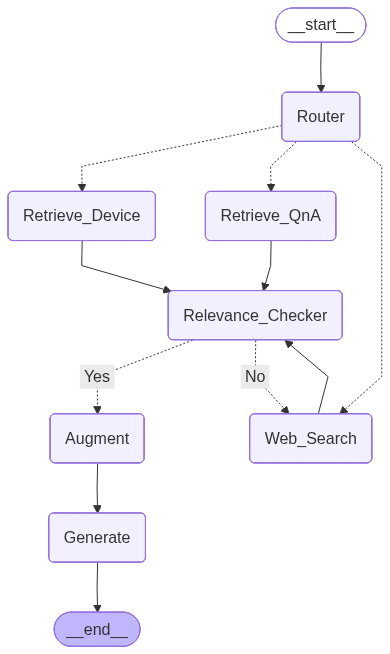

In [1]:
from typing import Literal
from langgraph.graph import StateGraph, MessagesState, START, END
from openai import OpenAI
from typing_extensions import TypedDict
from typing import List

# === Define the state structure ===
class GraphState(TypedDict):
    query: str
    context: str
    prompt: str
    response: str
    source: str  # Which retriever/tool was used
    is_relevant: str
    iteration_count: int

# === Define routing decision functions ===
def route_decision(state: GraphState) -> str:
    """Return the source from state to decide the routing path."""
    return state["source"]

def relevance_decision(state: GraphState) -> str:
    """Decide relevance path, with iteration limit."""
    iteration_count = state.get("iteration_count", 0)
    iteration_count += 1
    state["iteration_count"] = iteration_count
    ## Limiting to max 3 iterations
    if iteration_count >= 3:
        print("---MAX ITERATIONS REACHED, FORCING 'Yes'---")
        state["is_relevant"] = "Yes"
    return state["is_relevant"]

# === Define workflow node functions ===
def router(state: GraphState) -> Literal[
    "Retrieve_QnA", "Retrieve_Device", "Web_Search"
]:
    """Agentic router: decides which retrieval method to use."""
    query = state["query"]
    # A lightweight decision LLM - you can replace this with GPT-4o-mini, etc.
    decision_prompt = f"""
    You are a routing agent. Based on the user query, decide where to look for information.
    Options:
    - Retrieve_QnA: if it's about general medical knowledge, symptoms, or treatment.
    - Retrieve_Device: if it's about medical devices, manuals, or instructions.
    - Web_Search: if it's about recent news, brand names, or external data.
    Query: "{query}"
    Respond ONLY with one of: Retrieve_QnA, Retrieve_Device, Web_Search
    """
    router_decision = get_llm_response(decision_prompt).strip()
    print(f"---ROUTER DECISION: {router_decision}---")
    print(router_decision)
    state["source"] = router_decision
    return state

def retrieve_context_q_n_a(state: GraphState):
    """Retrieve top documents from ChromaDB Collection 1 (Medical Q&A Data) based on query."""
    print("---RETRIEVING CONTEXT---")
    query = state["query"] # last user message
    results = collection1.query(query_texts=[query], n_results=3)
    context = "\n".join(results["documents"][0])
    state["context"] = context
    state["source"] = "Medical Q&A Collection"
    print(context)
    # Save context in the state for later nodes
    return state

def retrieve_context_medical_device(state: GraphState):
    """Retrieve top documents from ChromaDB Collection 2 (Medical Device Manuals Data) based on query."""
    print("---RETRIEVING CONTEXT---")
    query = state["query"] # last user message
    results = collection2.query(query_texts=[query], n_results=3)
    context = "\n".join(results["documents"][0])
    state["context"] = context
    state["source"] = "Medical Device Manual"
    print(context)
    # Save context in the state for later nodes
    return state

def web_search(state: GraphState):
    """Perform web search using Google Serper API."""
    print("---PERFORMING WEB SEARCH---")
    query = state["query"]
    search_results = search.run(query=query)
    state["context"] = search_results
    state["source"] = "Web Search"
    print(search_results)
    return state

def build_prompt(state: GraphState):
    """Construct the RAG-style prompt."""
    print("---AUGMENT (BUILDING GENERATIVE PROMPT)---")
    query = state["query"]
    context = state["context"]
    prompt = f"""
            Answer the following question using the context below.
            Context:
            {context}
            Question: {query}
            please limit your answer in 50 words.
            """
    
    state["prompt"] = prompt
    print(prompt)
    return state

def call_llm(state: GraphState):
    """Call your existing LLM function."""
    print("---GENERATE (CALLING LLM)---")
    prompt = state["prompt"]
    answer = get_llm_response(prompt)
    state["response"] = answer
    return state

def check_context_relevance(state: GraphState):
    """Determine whether the retrieved context is relevant or not."""
    print("---CONTEXT RELEVANCE CHECKER---")
    query = state["query"]
    context = state["context"]
    relevance_prompt = f"""
            Check the below context if the context is relevent to the user query or.
            ####
            Context:
            {context}
            ####
            User Query: {query}
            Options:
            - Yes: if the context is relevant.
            - No: if the context is not relevant.
            Please answer with only 'Yes' or 'No'.
            """
    relevance_decision_value = get_llm_response(relevance_prompt).strip()
    print(f"---RELEVANCE DECISION: {relevance_decision_value}---")
    state["is_relevant"] = relevance_decision_value
    return state

# === Build the workflow ===
workflow = StateGraph(GraphState)
# Add nodes
workflow.add_node("Router", router)
workflow.add_node("Retrieve_QnA", retrieve_context_q_n_a)
workflow.add_node("Retrieve_Device", retrieve_context_medical_device)
workflow.add_node("Web_Search", web_search)
workflow.add_node("Relevance_Checker", check_context_relevance)
workflow.add_node("Augment", build_prompt)
workflow.add_node("Generate", call_llm)
# Define edges
workflow.add_edge(START, "Router")
workflow.add_conditional_edges(
    "Router",
    route_decision,  # this function decides the path dynamically
    {
        "Retrieve_QnA": "Retrieve_QnA",
        "Retrieve_Device": "Retrieve_Device",
        "Web_Search": "Web_Search",
    }
)
workflow.add_edge("Retrieve_QnA", "Relevance_Checker")
workflow.add_edge("Retrieve_Device", "Relevance_Checker")
workflow.add_edge("Web_Search", "Relevance_Checker")
workflow.add_conditional_edges(
    "Relevance_Checker",
    relevance_decision,  # this function decides the path dynamically
    {
        "Yes": "Augment",
        "No": "Web_Search",
    }
)
workflow.add_edge("Augment", "Generate")
workflow.add_edge("Generate", END)

# Compile the dynamic RAG agent
agentic_rag = workflow.compile()

# ===================================
# ===  Visualize Workflow (Optional) ===
# ===================================

# === Run it ===
from IPython.display import Image, display
display(Image(agentic_rag.get_graph().draw_mermaid_png()))